In [1]:
import tensorflow as tf
node1 = tf.constant(3.0, dtype=tf.float32)
node2 = tf.constant(4.0) # also tf.float32 implicitly
print(node1, node2)

/home/gao/anaconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Tensor("Const:0", shape=(), dtype=float32) Tensor("Const_1:0", shape=(), dtype=float32)


In [2]:
sess = tf.Session()
print(sess.run([node1, node2]))

[3.0, 4.0]


In [3]:
from __future__ import print_function
node3 = tf.add(node1, node2)
print("node3:", node3)
print("sess.run(node3):", sess.run(node3))

node3: Tensor("Add:0", shape=(), dtype=float32)
sess.run(node3): 7.0


In [4]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
adder_node = a + b  # + provides a shortcut for tf.add(a, b)
print(sess.run(adder_node, {a: 3, b: 4.5}))
print(sess.run(adder_node, {a: [1, 3], b: [2, 4]}))

7.5
[ 3.  7.]


In [5]:
add_and_triple = adder_node * 3.
print(sess.run(add_and_triple, {a: 3, b: 4.5}))

22.5


In [7]:
W = tf.Variable([.3], dtype=tf.float32)
b = tf.Variable([-.3], dtype=tf.float32)
x = tf.placeholder(tf.float32)
linear_model = W*x + b

init = tf.global_variables_initializer()
sess.run(init)

print(sess.run(linear_model, {x: [1, 2, 3, 4]}))

y = tf.placeholder(tf.float32)
squared_deltas = tf.square(linear_model - y)
loss = tf.reduce_sum(squared_deltas)
print(sess.run(loss, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))


[ 0.          0.30000001  0.60000002  0.90000004]
23.66


In [8]:
fixW = tf.assign(W, [-1.])
fixb = tf.assign(b, [1.])
sess.run([fixW, fixb])
print(sess.run(loss, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))

0.0


In [9]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)
sess.run(init) # reset values to incorrect defaults.
for i in range(1000):
  sess.run(train, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]})

print(sess.run([W, b]))

[array([-0.9999969], dtype=float32), array([ 0.99999082], dtype=float32)]


In [10]:
# full  code
import tensorflow as tf

# Model parameters
W = tf.Variable([.3], dtype=tf.float32)
b = tf.Variable([-.3], dtype=tf.float32)
# Model input and output
x = tf.placeholder(tf.float32)
linear_model = W*x + b
y = tf.placeholder(tf.float32)

# loss
loss = tf.reduce_sum(tf.square(linear_model - y)) # sum of the squares
# optimizer
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

# training data
x_train = [1, 2, 3, 4]
y_train = [0, -1, -2, -3]
# training loop
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init) # reset values to wrong
for i in range(1000):
  sess.run(train, {x: x_train, y: y_train})

# evaluate training accuracy
curr_W, curr_b, curr_loss = sess.run([W, b, loss], {x: x_train, y: y_train})
print("W: %s b: %s loss: %s"%(curr_W, curr_b, curr_loss))

W: [-0.9999969] b: [ 0.99999082] loss: 5.69997e-11


In [11]:
# high level code
import numpy as np
import tensorflow as tf

# Declare list of features, we only have one real-valued feature
def model_fn(features, labels, mode):
  # Build a linear model and predict values
  W = tf.get_variable("W", [1], dtype=tf.float64)
  b = tf.get_variable("b", [1], dtype=tf.float64)
  y = W*features['x'] + b
  # Loss sub-graph
  loss = tf.reduce_sum(tf.square(y - labels))
  # Training sub-graph
  global_step = tf.train.get_global_step()
  optimizer = tf.train.GradientDescentOptimizer(0.01)
  train = tf.group(optimizer.minimize(loss),
                   tf.assign_add(global_step, 1))
  # EstimatorSpec connects subgraphs we built to the
  # appropriate functionality.
  return tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=y,
      loss=loss,
      train_op=train)

estimator = tf.estimator.Estimator(model_fn=model_fn)
# define our data sets
x_train = np.array([1., 2., 3., 4.])
y_train = np.array([0., -1., -2., -3.])
x_eval = np.array([2., 5., 8., 1.])
y_eval = np.array([-1.01, -4.1, -7., 0.])
input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_train}, y_train, batch_size=4, num_epochs=None, shuffle=True)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_train}, y_train, batch_size=4, num_epochs=1000, shuffle=False)
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_eval}, y_eval, batch_size=4, num_epochs=1000, shuffle=False)

# train
estimator.train(input_fn=input_fn, steps=1000)
# Here we evaluate how well our model did.
train_metrics = estimator.evaluate(input_fn=train_input_fn)
eval_metrics = estimator.evaluate(input_fn=eval_input_fn)
print("train metrics: %r"% train_metrics)
print("eval metrics: %r"% eval_metrics)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsr4cmr38', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa4c05035c0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpsr4cmr38/model.ckpt.
INFO:tensorflow:loss = 11.6988813881, step = 1
INFO:tensorflow:global_step/sec: 573.767
INFO:tensorflow:loss = 0.408025450149, step = 101 (0.181 sec)
INFO:tensorflow:global_step/sec: 660.143
INFO:tensorflow:loss = 0.0389061654163, step = 201 (0.150 sec)
INFO:tensorflow:global_step/sec: 634.844
INFO:te

### 创建图、会话

In [2]:
import tensorflow as tf
m1 = tf.constant([[3,3]])
m2 = tf.constant([[2],[3]])
pro = tf.matmul(m1,m2)
print(pro)

Tensor("MatMul:0", shape=(1, 1), dtype=int32)


In [5]:
# sess = tf.Session()
# res = sess.run(pro)
# print(res)
# sess.close()
# some tips
with tf.Session() as sess:
    print(sess.run(pro))

[[15]]


### 变量

In [6]:
import tensorflow as tf

In [8]:
x = tf.Variable([1,2])
a = tf.constant([3,3])
sub = tf.subtract(x,a)
add = tf.add(x,sub)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    res1 = sess.run(sub)
    res2 = sess.run(add)
print(res1,res2)

[-2 -1] [-1  1]


In [12]:
state = tf.Variable(0,name='counter')
new_state = tf.add(state,1)
update = tf.assign(state,new_state)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(state))
    for _ in range(5):
        print(sess.run(update))
#         print(sess.run(state))

0
1
2
3
4
5


### Feed

In [13]:
in1 = tf.placeholder(tf.float32)
in2 = tf.placeholder(tf.float32)
ot = tf.multiply(in1,in2)
with tf.Session() as sess:
    #以字典的形式传入数据
    res = sess.run(ot,feed_dict={in1:[8.],in2:[2.]})
    print(res)

[ 16.]


### Fetch

In [16]:
in1 = tf.constant(3.0)
in2 = tf.constant(2.0)

add = tf.add(in1,in2)
mul = tf.multiply(add,in1)
with tf.Session() as sess:
    # session 传入多个node
    res = sess.run([add,mul])
    print(res)

[5.0, 15.0]


## 小Demo

In [17]:
import tensorflow as tf
import numpy as np

In [23]:
x_data = np.random.rand(100)
y_data = x_data * 0.1 + 0.2
#linear model
k = tf.Variable(0.)
b = tf.Variable(0.)
y = k * x_data + b
#loss function
loss = tf.reduce_mean(tf.square(y_data - y))
#GD
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.2)
#train
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for _ in range(500):
        sess.run(train)
    print(sess.run([k,b]))

[0.10000022, 0.19999987]


## 神经网络

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/home/gao/anaconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


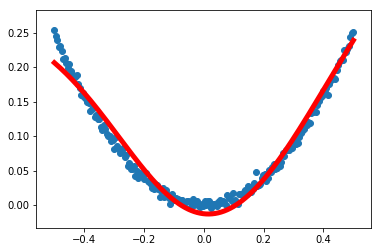

In [26]:
x_data = np.linspace(-0.5,0.5,200)[:,np.newaxis]
noise = np.random.normal(0,0.005,x_data.shape)
y_data = np.square(x_data) + noise

x = tf.placeholder(tf.float32,[None,1])
y = tf.placeholder(tf.float32,[None,1])

#中间层
Weights_L1 = tf.Variable(tf.random_normal([1,10]))
biases_L1 = tf.Variable(tf.zeros([1,10]))
Wx_plus_b_L1 = tf.matmul(x,Weights_L1) + biases_L1
L1 = tf.nn.tanh(Wx_plus_b_L1)

#output layer
Weights_L2 = tf.Variable(tf.random_normal([10,1]))
biases_L2 = tf.Variable(tf.zeros([1,1]))
Wx_plus_b_L2 = tf.matmul(L1,Weights_L2) + biases_L2
prediction = tf.nn.tanh(Wx_plus_b_L2)

loss = tf.reduce_mean(tf.square(y-prediction))
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for _ in range(2000):
        sess.run(train_step,feed_dict={x:x_data,y:y_data})
    prediction_value = sess.run(prediction,feed_dict={x:x_data})
plt.figure()
plt.scatter(x_data,y_data)
plt.plot(x_data,prediction_value,'r-',lw=5)
plt.show()

### mnist

In [27]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [ ]:
mnist = input_data.read_data_sets('MNIST_data',one_hot=True)
batch_size = 100
 